In [15]:
import numpy as np                   
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import rasterio
import re
import netCDF4 as nc

sns.set_style("darkgrid")
sns.set_context("paper")
%matplotlib inline
plt.rcParams["font.sans-serif"]='SimHei'   
plt.rcParams['axes.unicode_minus']=False   
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',8)             
pd.set_option('display.max_rows',15)

### 地形数据

In [16]:
with rasterio.open(r'F:\研究生学习\华为杯\第三问最终代码\python\chdem_105.tif') as df1:
    value1 = df1.read(1) 
    value1 = value1.astype(np.float32)
    value1[value1<-500] = np.nan      
    bounds1 = df1.bounds
    left1,bottom1,right1,top1 = bounds1
    transform1 = df1.transform
    xvalue1 = df1.width
    yvalue1 = df1.height
    xaltitude1 = np.linspace(left1,right1,xvalue1)
    yaltitude1 = np.linspace(bottom1,top1,yvalue1)
    Xaltitude1, Yaltitude1 = np.meshgrid(xaltitude1, yaltitude1)   
df1_output = pd.DataFrame(value1)

with rasterio.open(r'F:\研究生学习\华为杯\第三问最终代码\python\chdem_Aspect.tif') as df2:
    value2 = df2.read(1)  
    value2[value2<-500] = np.nan      
    bounds2 = df2.bounds
    left2,bottom2,right2,top2 = bounds2
    transform2 = df2.transform
    xvalue2 = df2.width
    yvalue2 = df2.height
    xaltitude2 = np.linspace(left2,right2,xvalue2)
    yaltitude2 = np.linspace(bottom2,top2,yvalue2)
    Xaltitude2, Yaltitude2 = np.meshgrid(xaltitude2, yaltitude2)
df2_output = pd.DataFrame(value2)

with rasterio.open(r'F:\研究生学习\华为杯\第三问最终代码\python\chdem_Slope.tif') as df3:
    value3 = df3.read(1)  
    value3[value3<-5000] = np.nan      
    bounds3 = df3.bounds
    left3,bottom3,right3,top3 = bounds3
    transform3 = df3.transform
    xvalue3 = df3.width
    yvalue3 = df3.height
    xaltitude3 = np.linspace(left3,right3,xvalue3)
    yaltitude3 = np.linspace(bottom3,top3,yvalue3)
    Xaltitude3, Yaltitude3 = np.meshgrid(xaltitude3, yaltitude3)
df3_output = pd.DataFrame(value3)

crop=pd.read_excel('F:\研究生学习\华为杯\第三问最终代码\python\crop_data1.xlsx')

## 地形得分，海拔越高，坡度越大，脆弱性得分越高

In [17]:
def crop_to_divisible(matrix, target_shape):
    new_height = (matrix.shape[0] // target_shape[0]) * target_shape[0]
    new_width = (matrix.shape[1] // target_shape[1]) * target_shape[1]
    return matrix[:new_height, :new_width]

def downsample_matrix(matrix, target_shape):
    matrix_cropped = crop_to_divisible(matrix, target_shape)
    factor_x = matrix_cropped.shape[0] // target_shape[0]
    factor_y = matrix_cropped.shape[1] // target_shape[1]
    downsampled = matrix_cropped.reshape(target_shape[0], factor_x, target_shape[1], factor_y).mean(axis=(1, 3))
    return downsampled

df1_output=df1_output.fillna(0) 
large_matrix = df1_output.values
small_matrix = crop.values
df_gao = downsample_matrix(large_matrix, small_matrix.shape)
df_gao = pd.DataFrame(df_gao)

df2_output=df2_output.fillna(0) 
large_matrix = df2_output.values
df_px = downsample_matrix(large_matrix, small_matrix.shape)
df_px = pd.DataFrame(df_px)

df3_output=df3_output.fillna(0) 
large_matrix = df3_output.values
df_pd = downsample_matrix(large_matrix, small_matrix.shape)
df_pd = pd.DataFrame(df_pd)

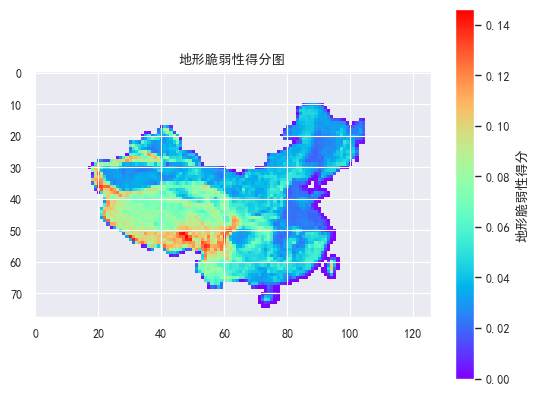

In [45]:
def l2_normalize_matrix(matrix):
    l2_norm = np.linalg.norm(matrix, ord=2)
    if l2_norm == 0:
        return matrix  
    normalized_matrix = matrix / l2_norm
    return normalized_matrix
import warnings

# 忽略所有的警告
warnings.filterwarnings("ignore")
# 设置字体为 SimHei（黑体）以支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 解决负号
matrix = df_gao.values  
df_gao = l2_normalize_matrix(matrix)
df_gao = pd.DataFrame(df_gao)
matrix = df_px.values  
df_px = l2_normalize_matrix(matrix)
df_px = pd.DataFrame(df_px)
matrix = df_pd.values  
df_pd = l2_normalize_matrix(matrix)
df_pd = pd.DataFrame(df_pd)
score1=df_gao+df_px+df_pd
score1=score1.replace(0,np.nan) 
plt.imshow(score1,cmap='rainbow')
plt.colorbar(label='地形脆弱性得分')
plt.title('地形脆弱性得分图')
plt.savefig('F:\研究生学习\华为杯\第三问图片\地形脆弱度得分.png',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')

## 土地类型得分

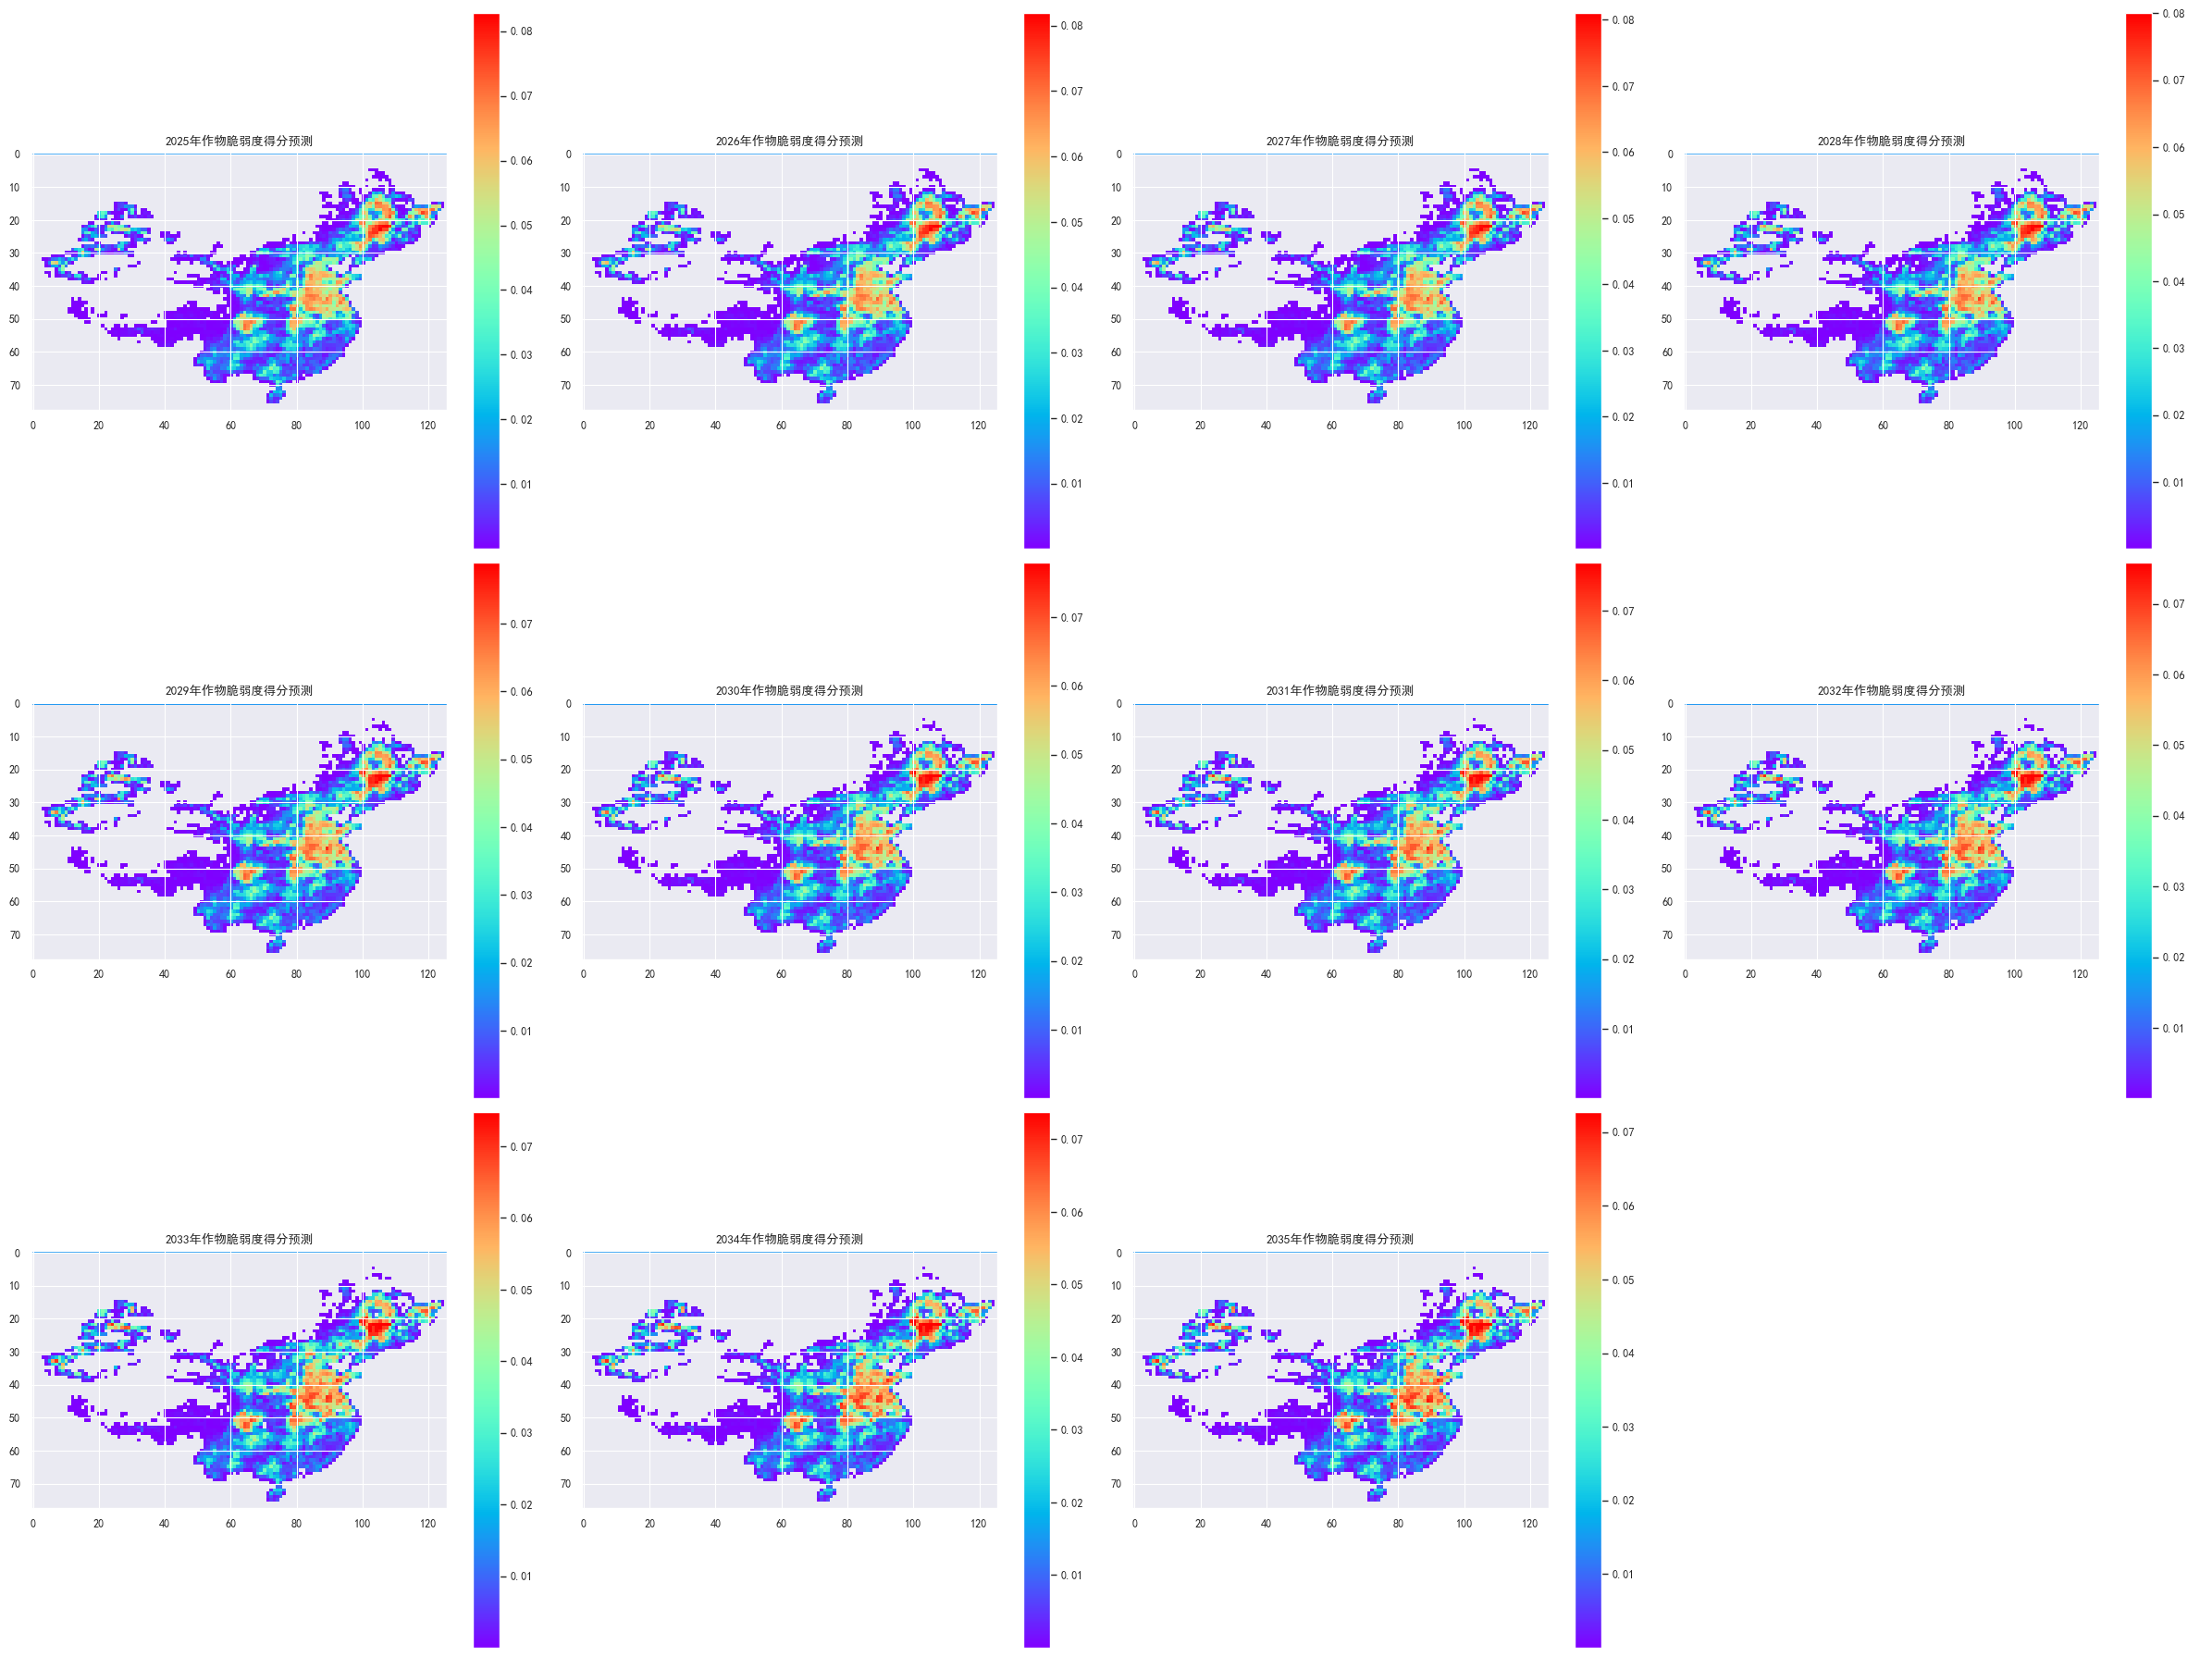

In [65]:
excel_file_path = 'F:\研究生学习\华为杯\第三问最终代码\python\crop_data1.xlsx' 
excel_data = pd.ExcelFile(excel_file_path)
sheet_names = excel_data.sheet_names 

fig,axes = plt.subplots(3,4,figsize=(24,18))
    
for idx, sheet_name in enumerate(sheet_names):
    year = int(sheet_name.split()[0])
    matrix = excel_data.parse(sheet_name).values
    l2 = l2_normalize_matrix(matrix)
    l3 = pd.DataFrame(l2)
    l3=l3.replace(0,np.nan) 
    # ax = axes[idx // 2, idx % 2]  
    row = idx // 4  # 整数除法得到行索引  
    col = idx % 4   # 求余得到列索引  
    ax = axes[row, col]
    cax = ax.imshow(l3,cmap='rainbow')
    fig.colorbar(cax,ax=ax)
    ax.set_title(f'{year}年作物脆弱度得分预测')

axes[-1,-1].axis('off')     
plt.tight_layout()
plt.savefig('F:\研究生学习\华为杯\第三问图片\crop脆弱度得分.png',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')
plt.show()

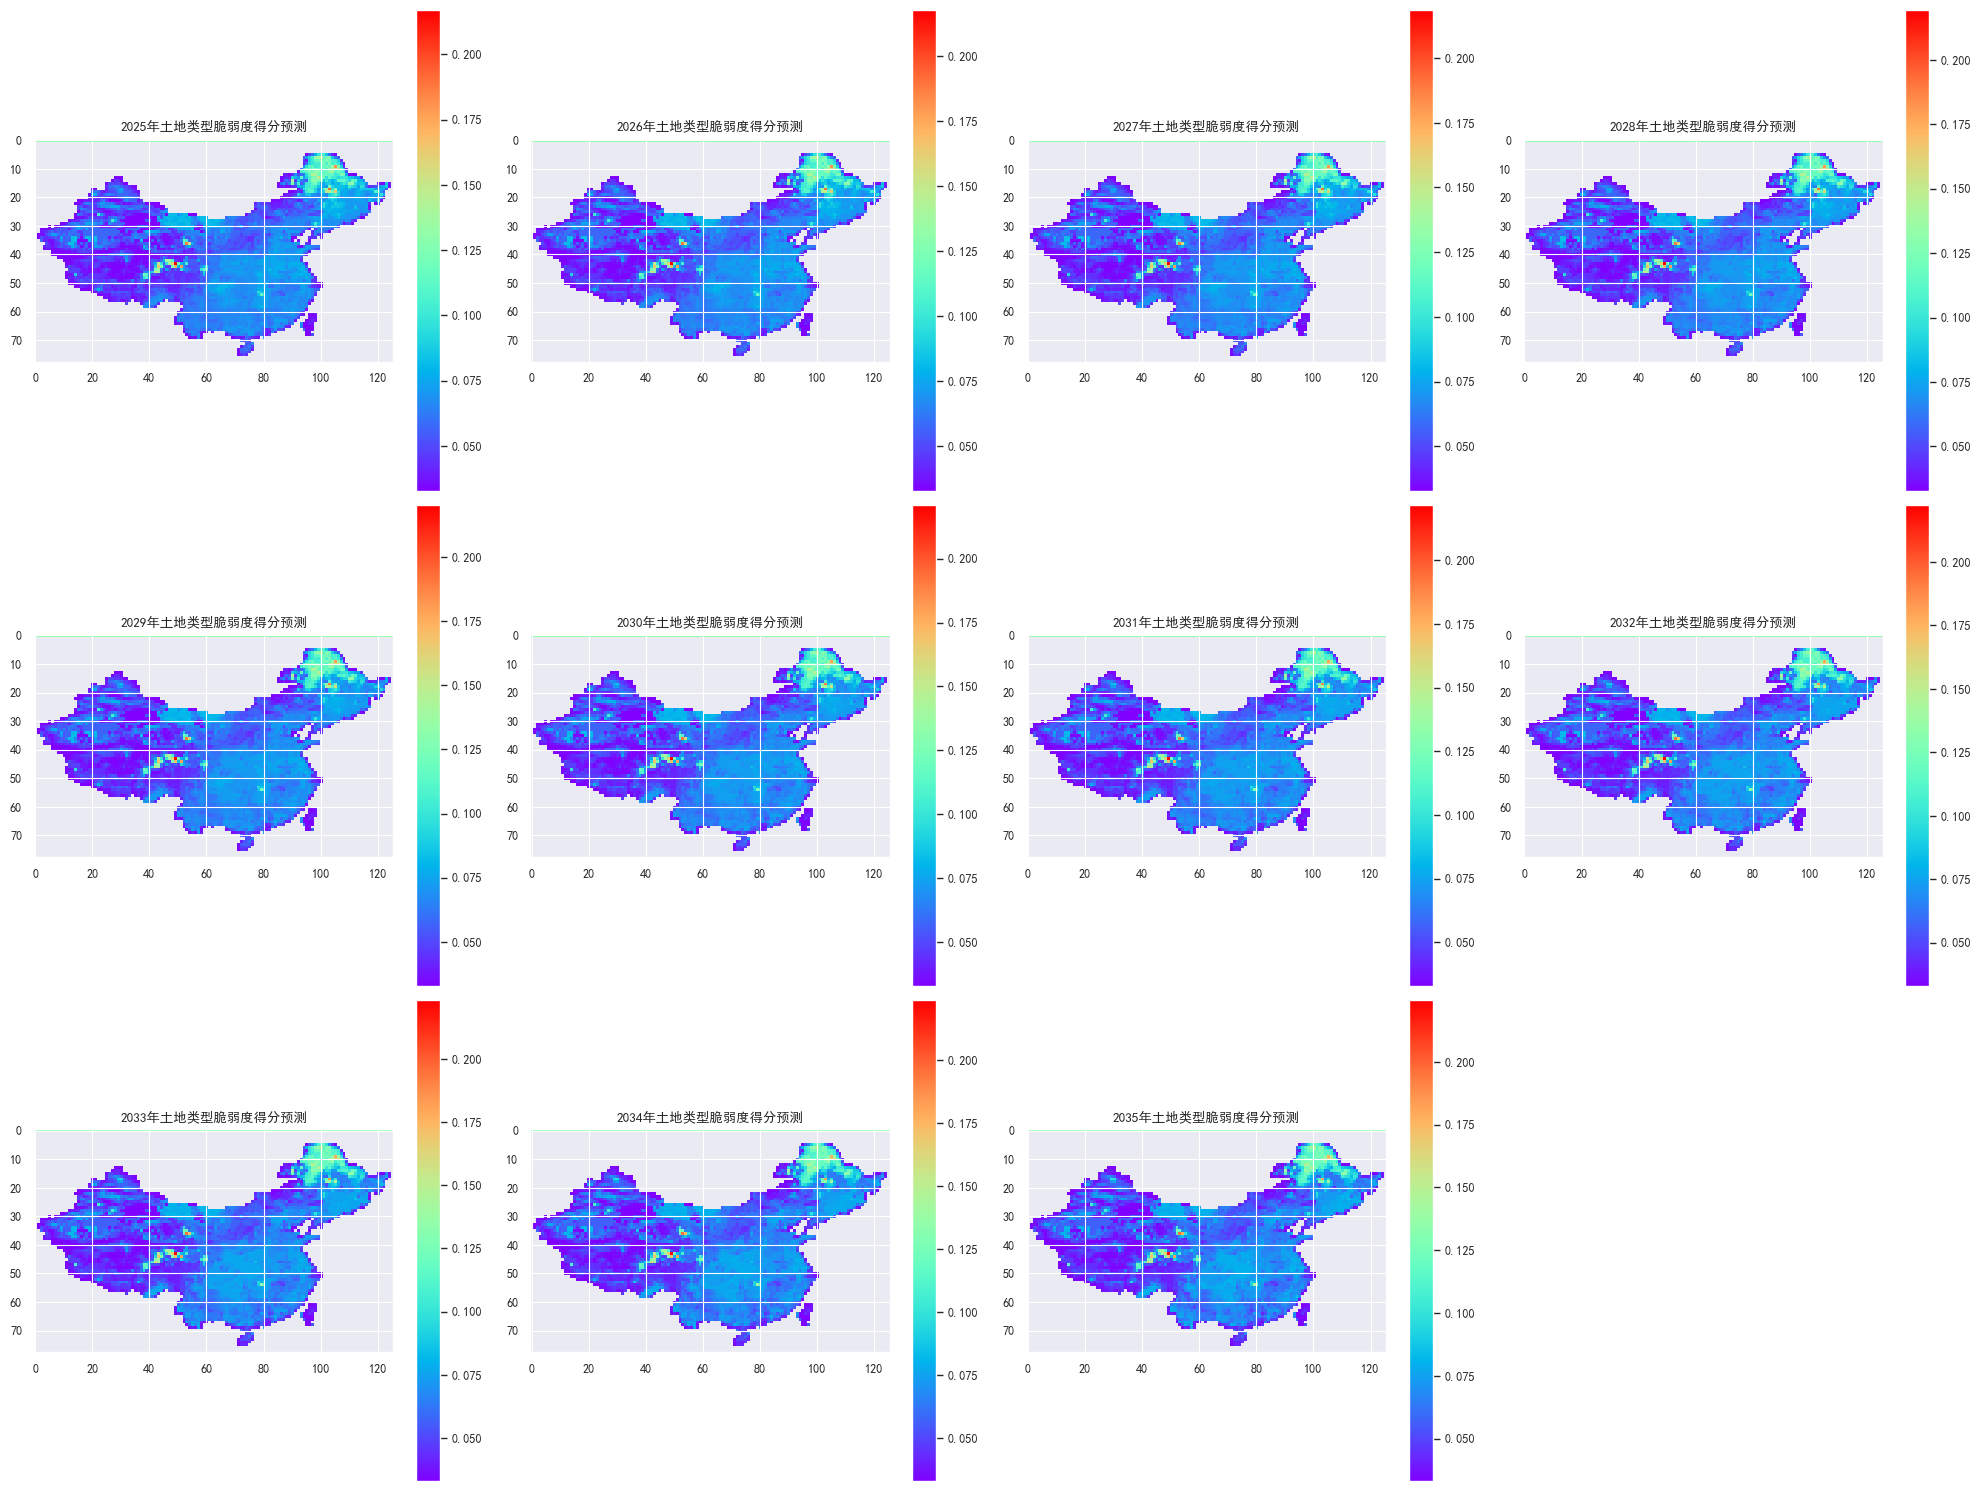

In [60]:
excel_file_paths = [
    'F:\研究生学习\华为杯\第三问最终代码\python\crop_data1.xlsx',
    'F:\研究生学习\华为杯\第三问最终代码\python\\forest_data1.xlsx',
    'F:\研究生学习\华为杯\第三问最终代码\python\grass_data1.xlsx',
    'F:\研究生学习\华为杯\第三问最终代码\python\shrub_data1.xlsx',
    'F:\研究生学习\华为杯\第三问最终代码\python\wet_data1.xlsx']

all_excel_data = []
for file_path in excel_file_paths:
    excel_data = pd.ExcelFile(file_path)
    all_excel_data.append(excel_data)

sheet_names = all_excel_data[0].sheet_names 
fig,axes = plt.subplots(3,4,figsize=(24,18))

for idx, sheet_name in enumerate(sheet_names):
    year = int(sheet_name.split()[0])

    
    combined_matrix = None
    for excel_data in all_excel_data:
        matrix = excel_data.parse(sheet_name).values  
        normalized_matrix = l2_normalize_matrix(matrix)  
        if combined_matrix is None:
            combined_matrix = normalized_matrix
        else:
            combined_matrix += normalized_matrix  
    combined_df = pd.DataFrame(combined_matrix)
    combined_df = combined_df.replace(0, np.nan)
    # ax = axes[idx // 2, idx % 2] 
    row = idx // 4  # 整数除法得到行索引  
    col = idx % 4   # 求余得到列索引  
    ax = axes[row, col]
    cax = ax.imshow(combined_df,cmap='rainbow')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{year}年土地类型脆弱度得分预测')

axes[-1,-1].axis('off')
plt.tight_layout()
plt.savefig('F:\研究生学习\华为杯\第三问图片\土地类型脆弱度得分.png',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')
plt.show()

## 整体得分

In [22]:
def crop_to_divisible(matrix, target_shape):
    new_height = (matrix.shape[0] // target_shape[0]) * target_shape[0]
    new_width = (matrix.shape[1] // target_shape[1]) * target_shape[1]
    return matrix[:new_height, :new_width]

def downsample_matrix(matrix, target_shape):
    matrix_cropped = crop_to_divisible(matrix, target_shape)
    factor_x = matrix_cropped.shape[0] // target_shape[0]
    factor_y = matrix_cropped.shape[1] // target_shape[1]
    downsampled = matrix_cropped.reshape(target_shape[0], factor_x, target_shape[1], factor_y).mean(axis=(1, 3))
    return downsampled

small_matrix = crop.values  
excel_file_path = 'F:\研究生学习\华为杯\第三问最终代码\python\降雨量预测.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)

output_excel_path = 'F:\研究生学习\华为杯\第三问最终代码\python\降雨量预测+.xlsx'
writer = pd.ExcelWriter(output_excel_path, engine='xlsxwriter')

for sheet_name in excel_data.sheet_names:
    large_matrix = excel_data.parse(sheet_name).values  
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    downsampled_df = pd.DataFrame(downsampled_matrix)
    downsampled_df = downsampled_df.fillna(0)
    downsampled_df.to_excel(writer, sheet_name=sheet_name, index=False)
writer.save()

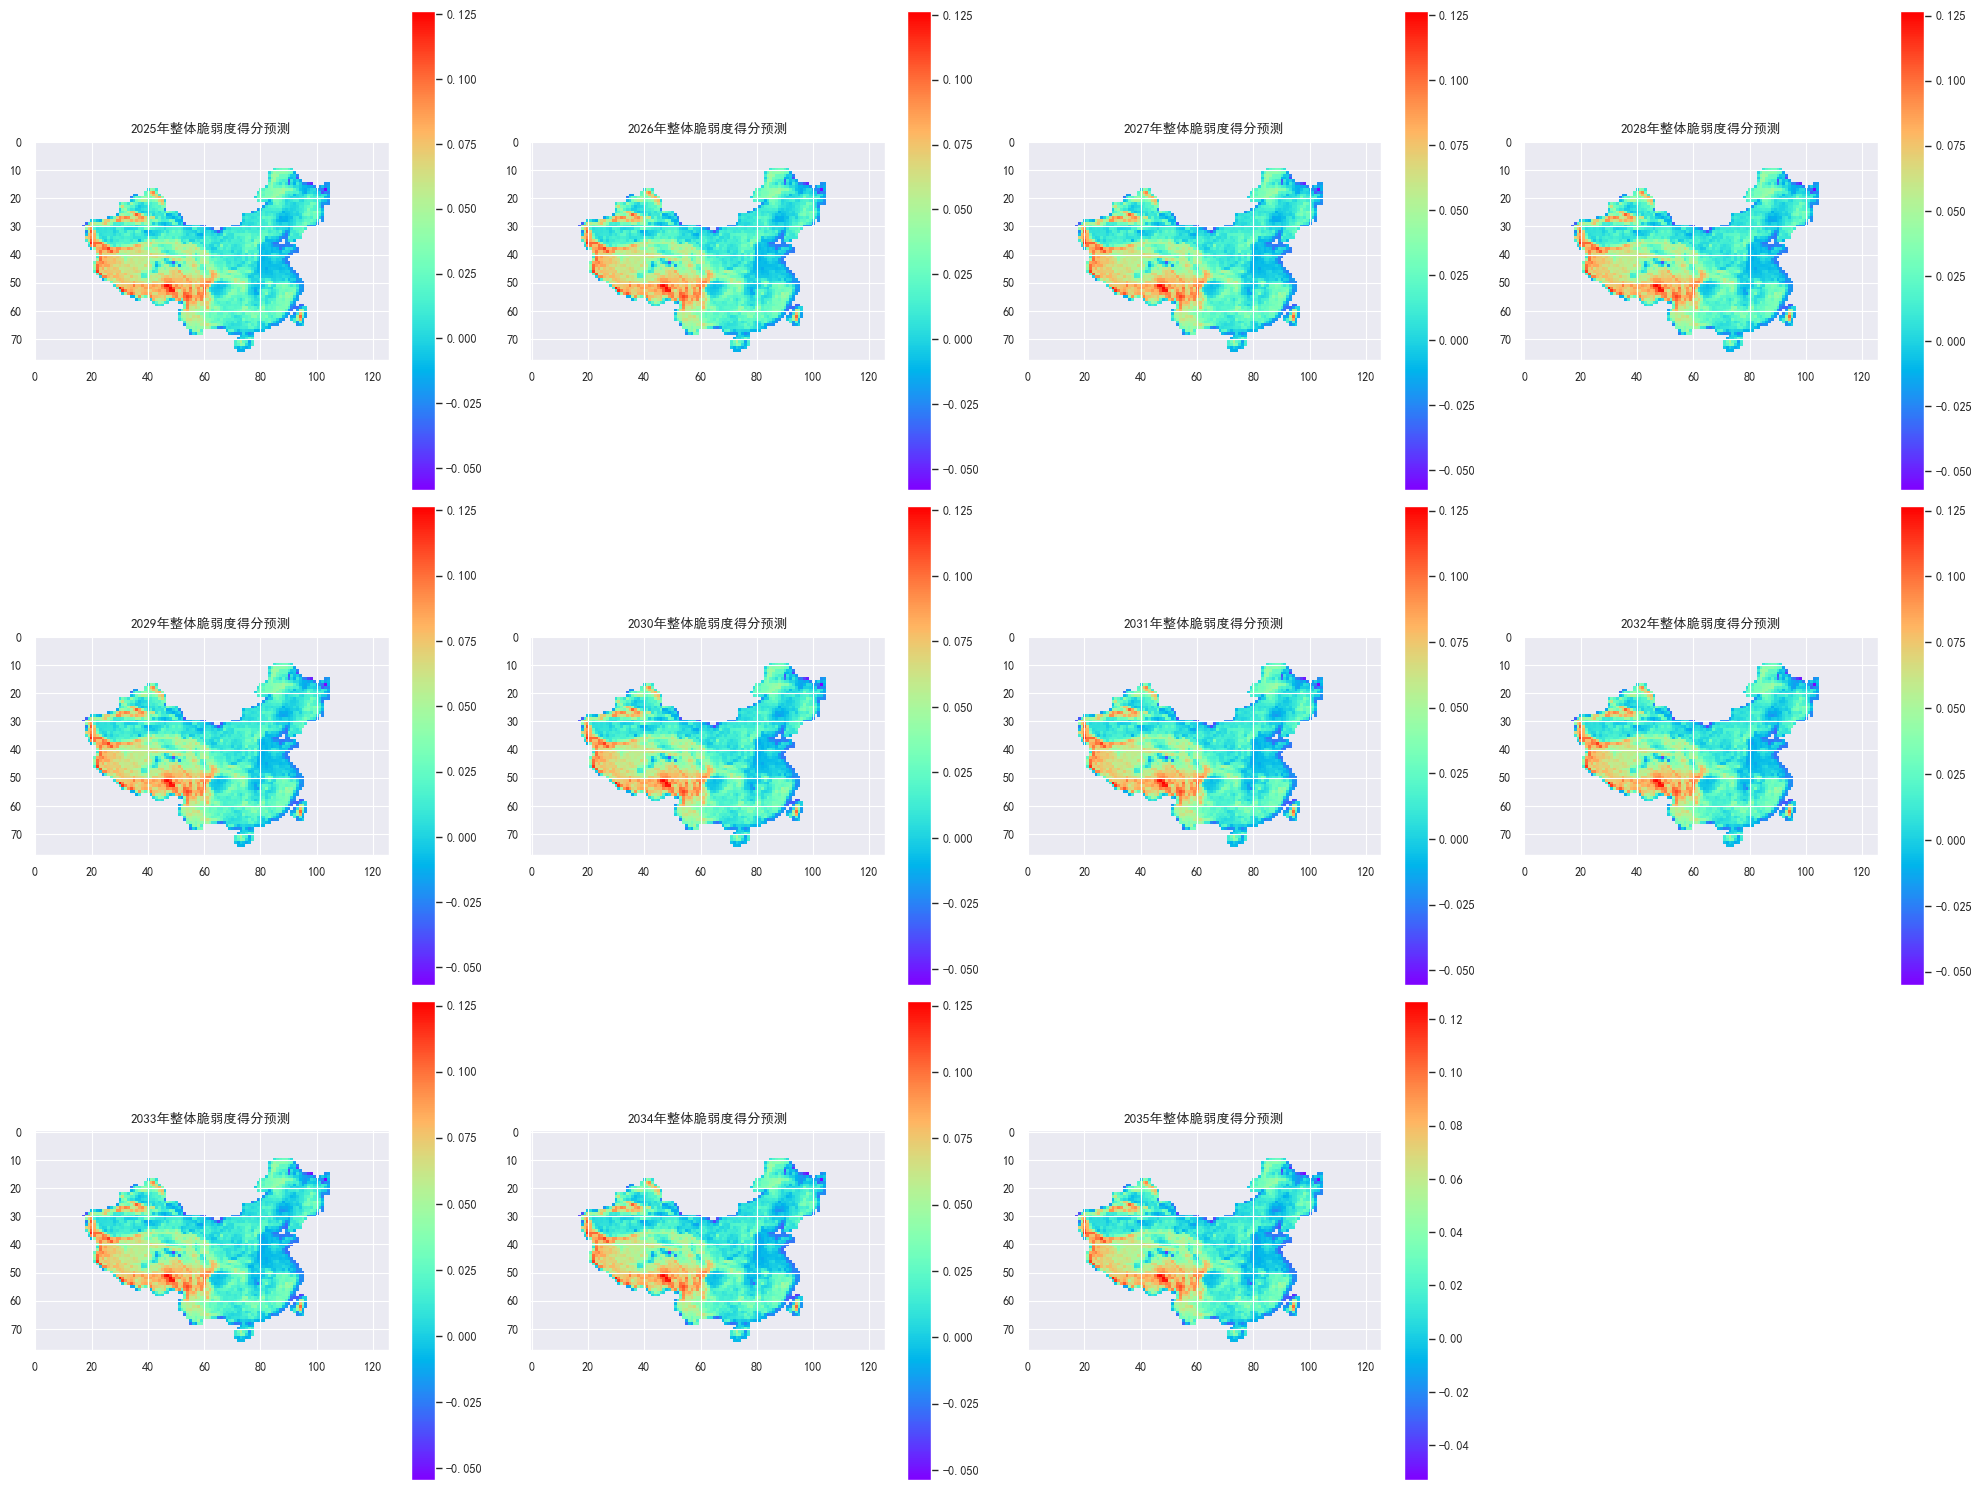

In [49]:
excel_file_paths = [
    'F:\研究生学习\华为杯\第三问最终代码\python\crop_data1.xlsx',
    'F:\研究生学习\华为杯\第三问最终代码\python\\forest_data1.xlsx',
    'F:\研究生学习\华为杯\第三问最终代码\python\grass_data1.xlsx',
    'F:\研究生学习\华为杯\第三问最终代码\python\shrub_data1.xlsx',
    'F:\研究生学习\华为杯\第三问最终代码\python\wet_data1.xlsx',
    'F:\研究生学习\华为杯\第三问最终代码\python\降雨量预测+.xlsx']

all_excel_data = []
for file_path in excel_file_paths:
    excel_data = pd.ExcelFile(file_path)
    all_excel_data.append(excel_data)

sheet_names = all_excel_data[0].sheet_names 
fig,axes = plt.subplots(3,4,figsize=(20,15))

for idx, sheet_name in enumerate(sheet_names):
    year = int(sheet_name.split()[0])

    combined_matrix = None
    for excel_data in all_excel_data:
        matrix = excel_data.parse(sheet_name).values  
        normalized_matrix = l2_normalize_matrix(matrix)  
        if combined_matrix is None:
            combined_matrix = normalized_matrix
        else:
            combined_matrix += normalized_matrix  
    
    subtract_matrix = all_excel_data[5].parse(sheet_name).values
    normalized_subtract_matrix = l2_normalize_matrix(subtract_matrix)  

    final_matrix = -0.5*combined_matrix+normalized_subtract_matrix+score1

    final_df = pd.DataFrame(final_matrix)
    final_df = final_df.replace(0, np.nan)
    # ax = axes[idx // 2, idx % 2] 
    # 计算轴的位置  
    row = idx // 4  # 整数除法得到行索引  
    col = idx % 4   # 求余得到列索引  
    ax = axes[row, col] 
    cax = ax.imshow(final_df,cmap='rainbow')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{year}年整体脆弱度得分预测')

axes[-1,-1].axis('off')
plt.tight_layout()
plt.savefig('F:\研究生学习\华为杯\第三问图片\整体脆弱度得分.png',
            dpi=500,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')
plt.show()

In [32]:
def read_tif(file_path):  
    with rasterio.open(file_path) as src:
        band_data = src.read(1).astype(np.float32) 
        return band_data, src.bounds, src.transform, src.width, src.height

def extract_year_from_filename(file_name):
    match = re.search(r'(\d{4})', file_name)
    if match:
        return int(match.group(1))
    raise ValueError(f"Could not extract year from file name: {file_name}")

def process_folder(folder_path):
    data_dict = {}
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tif'):
            year = extract_year_from_filename(file_name)
            if 1990 <= year <= 2015:
                tif_path = os.path.join(folder_path, file_name)
                
                value, bounds, transform, xvalue, yvalue = read_tif(tif_path)
                value[value < -100] = np.nan
                left, bottom, right, top = bounds
                xaltitude = np.linspace(left, right, xvalue)
                yaltitude = np.linspace(bottom, top, yvalue)
                df_output = pd.DataFrame(value)
                data_dict[year] = df_output
    
    return data_dict

def save_to_csv(data_dict, output_folder):
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for year, df in data_dict.items():
        output_csv_path = os.path.join(output_folder, f'{year}.csv')
        df.to_csv(output_csv_path, index=False)
        print(f"Saved data for year {year} to {output_csv_path}")


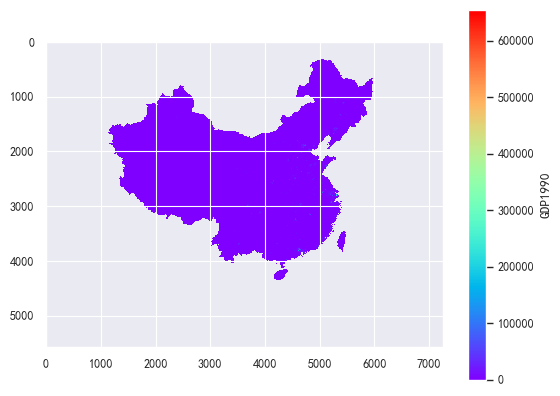

In [36]:
gdp1=pd.read_csv('F:\研究生学习\华为杯\研赛第四问数据\GDP_CSV\\1990.csv')
plt.imshow(gdp1,cmap='rainbow')
plt.colorbar(label='GDP1990')

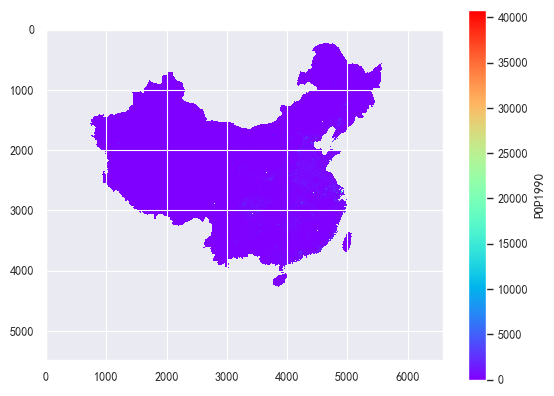

In [38]:
pop1=pd.read_csv('F:\研究生学习\华为杯\研赛第四问数据\POP_CSV\\1990.csv')
plt.imshow(pop1,cmap='rainbow')
plt.colorbar(label='POP1990')

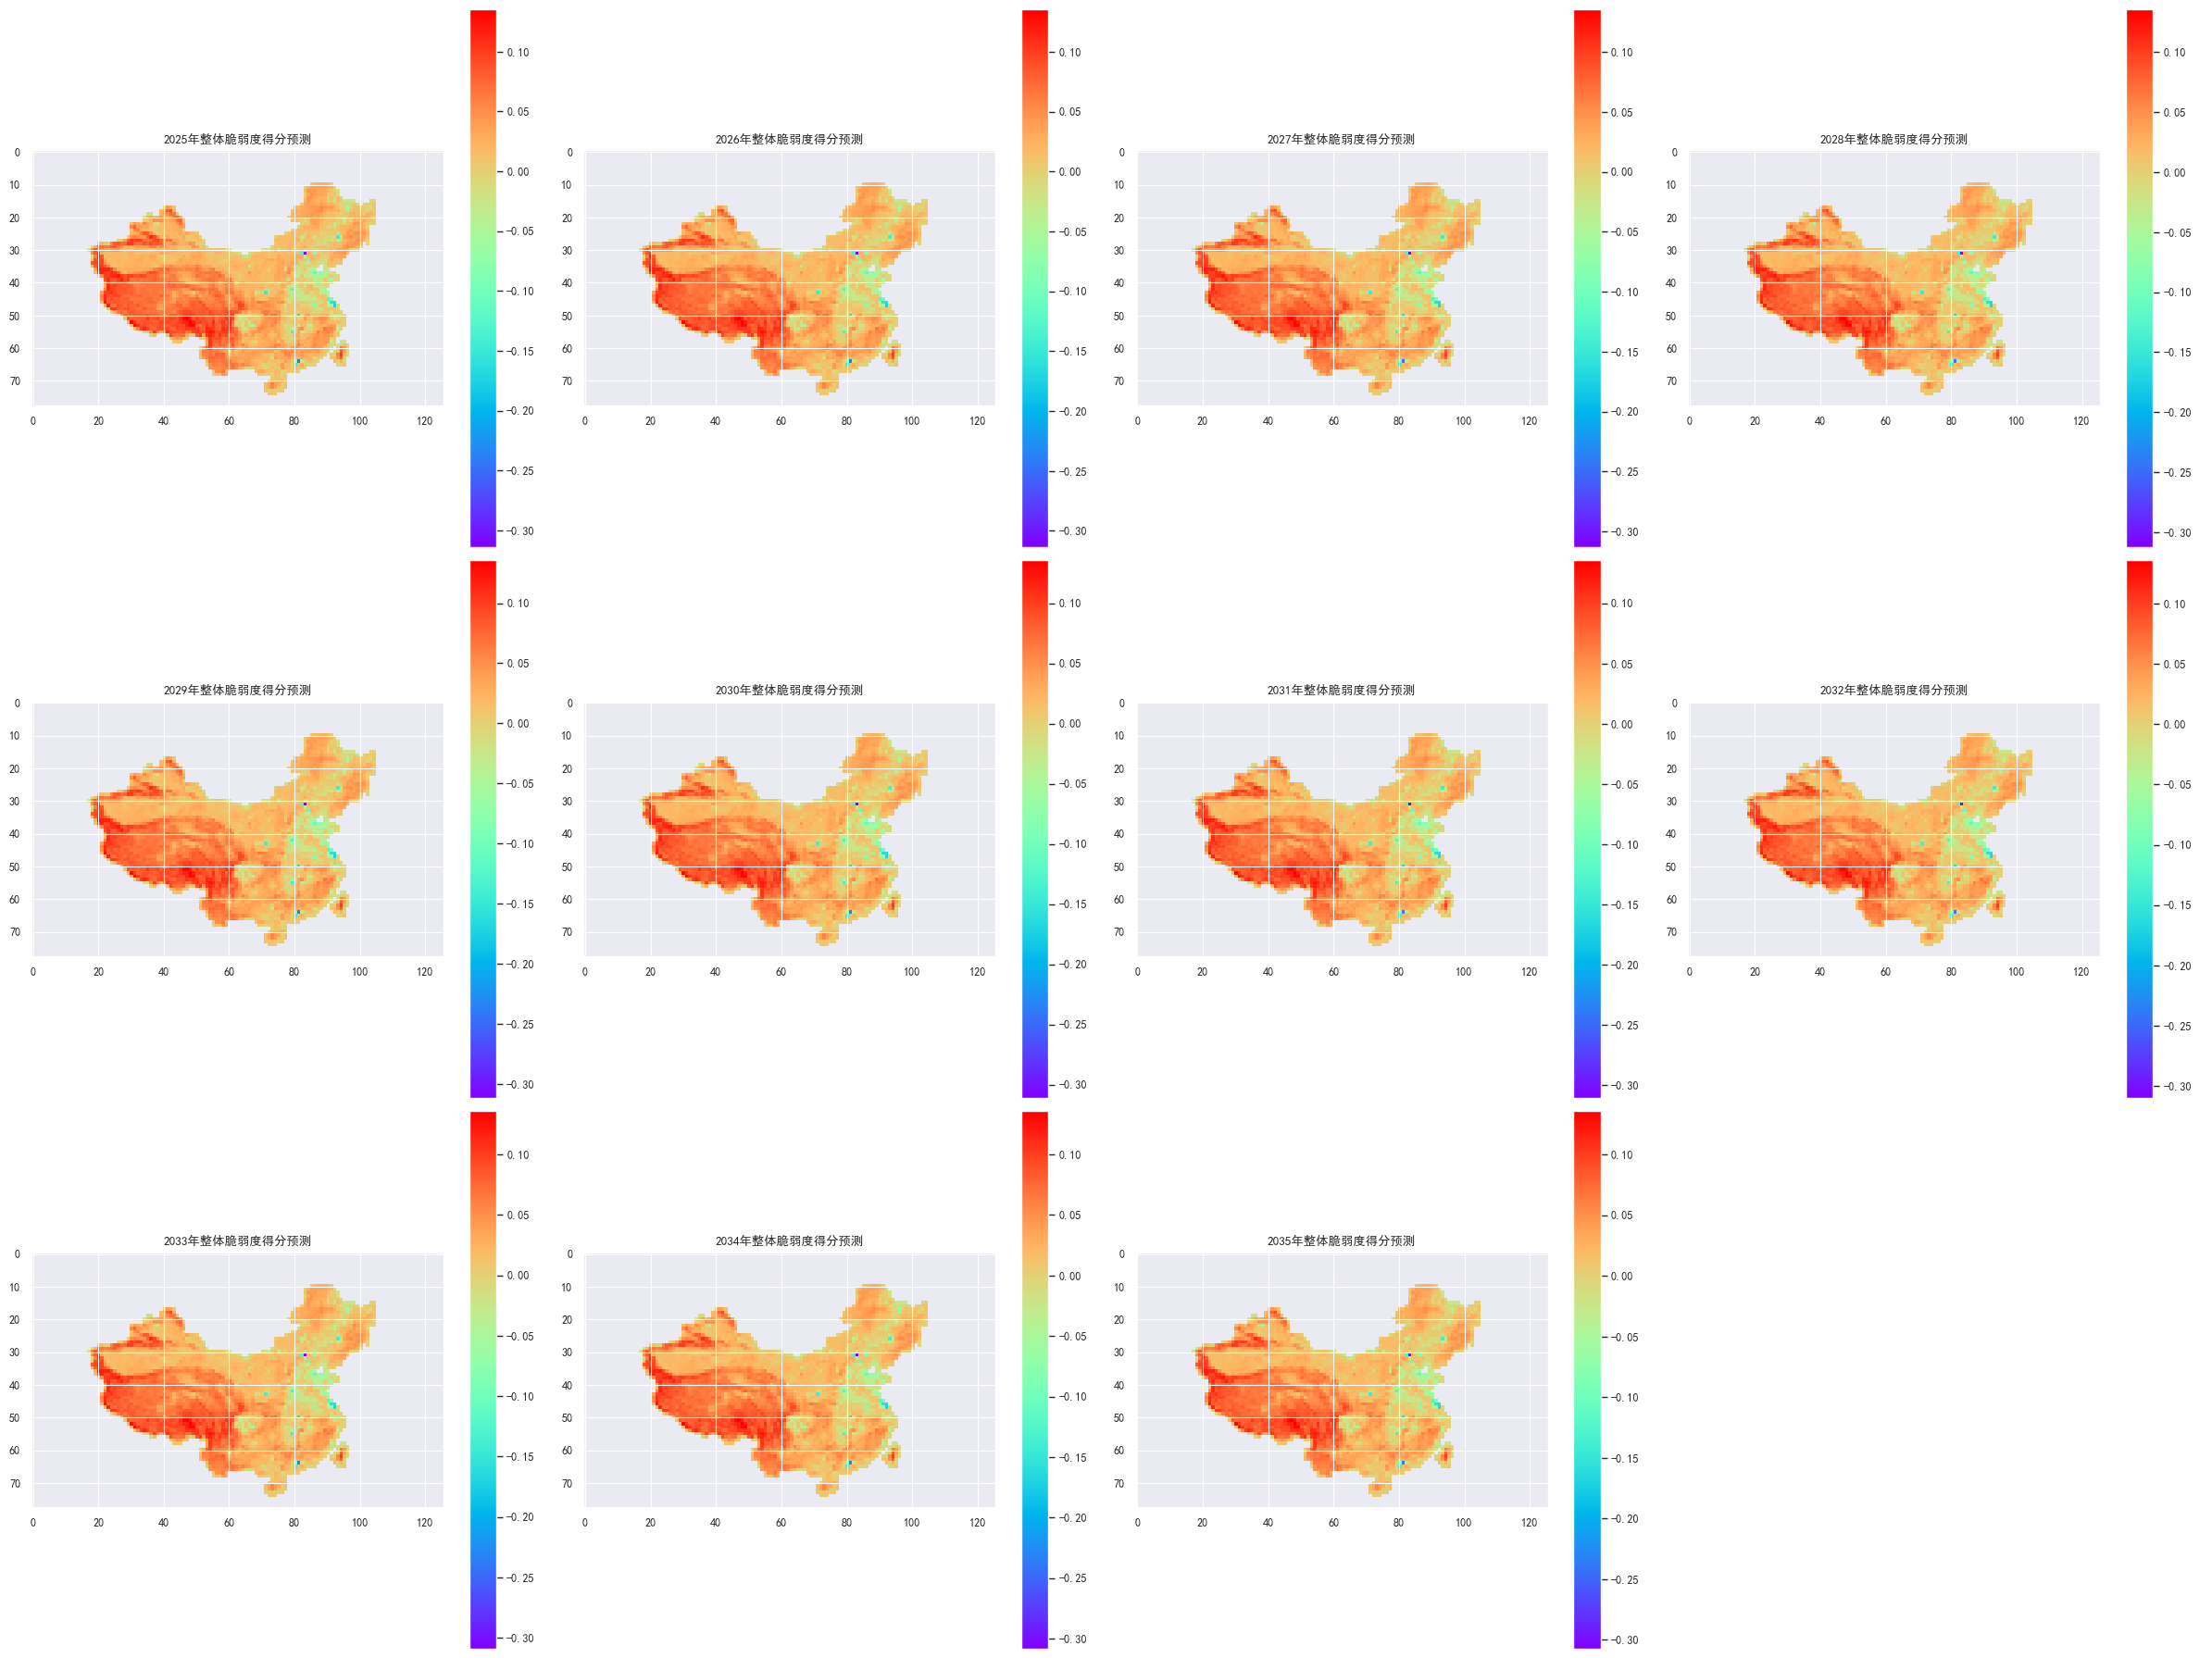

In [51]:
excel_file_paths = [
    'F:\研究生学习\华为杯\第四问最终代码\python\crop_data1.xlsx',
    'F:\研究生学习\华为杯\第四问最终代码\python\\forest_data1.xlsx',
    'F:\研究生学习\华为杯\第四问最终代码\python\grass_data1.xlsx',
    'F:\研究生学习\华为杯\第四问最终代码\python\shrub_data1.xlsx',
    'F:\研究生学习\华为杯\第四问最终代码\python\wet_data1.xlsx',
    'F:\研究生学习\华为杯\第四问最终代码\python\降雨量预测+.xlsx',
    'F:\研究生学习\华为杯\第四问最终代码\python\G1.xlsx',
    'F:\研究生学习\华为杯\第四问最终代码\python\P1.xlsx']

all_excel_data = []
for file_path in excel_file_paths:
    excel_data = pd.ExcelFile(file_path)
    all_excel_data.append(excel_data)

sheet_names = all_excel_data[0].sheet_names 
fig,axes = plt.subplots(3,4,figsize=(24,18))

for idx, sheet_name in enumerate(sheet_names):
    year = int(sheet_name.split()[0])
    
    combined_matrix = None
    for excel_data in all_excel_data:
        matrix = excel_data.parse(sheet_name).values  
        normalized_matrix = l2_normalize_matrix(matrix)  
        if combined_matrix is None:
            combined_matrix = normalized_matrix
        else:
            combined_matrix += normalized_matrix  
    
    subtract_matrix1 = all_excel_data[5].parse(sheet_name).values
    normalized_subtract_matrix1 = l2_normalize_matrix(subtract_matrix1) 
    subtract_matrix2 = all_excel_data[6].parse(sheet_name).values
    normalized_subtract_matrix2 = l2_normalize_matrix(subtract_matrix2) 
    subtract_matrix3 = all_excel_data[7].parse(sheet_name).values
    normalized_subtract_matrix3 = l2_normalize_matrix(subtract_matrix3) 

    final_matrix = -0.3*combined_matrix+normalized_subtract_matrix1+score1-0.01*normalized_subtract_matrix2-0.01*normalized_subtract_matrix3

    final_df = pd.DataFrame(final_matrix)
    final_df = final_df.replace(0, np.nan)
    # ax = axes[idx // 2, idx % 2] 
    # 计算轴的位置  
    row = idx // 4  # 整数除法得到行索引  
    col = idx % 4   # 求余得到列索引  
    ax = axes[row, col] 
    cax = ax.imshow(final_df,cmap='rainbow')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{year}年整体脆弱度得分预测')
axes[-1,-1].axis('off')
plt.tight_layout()
plt.savefig('F:\研究生学习\华为杯\第四问图片\第四问整体脆弱度得分.png',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')
plt.show()

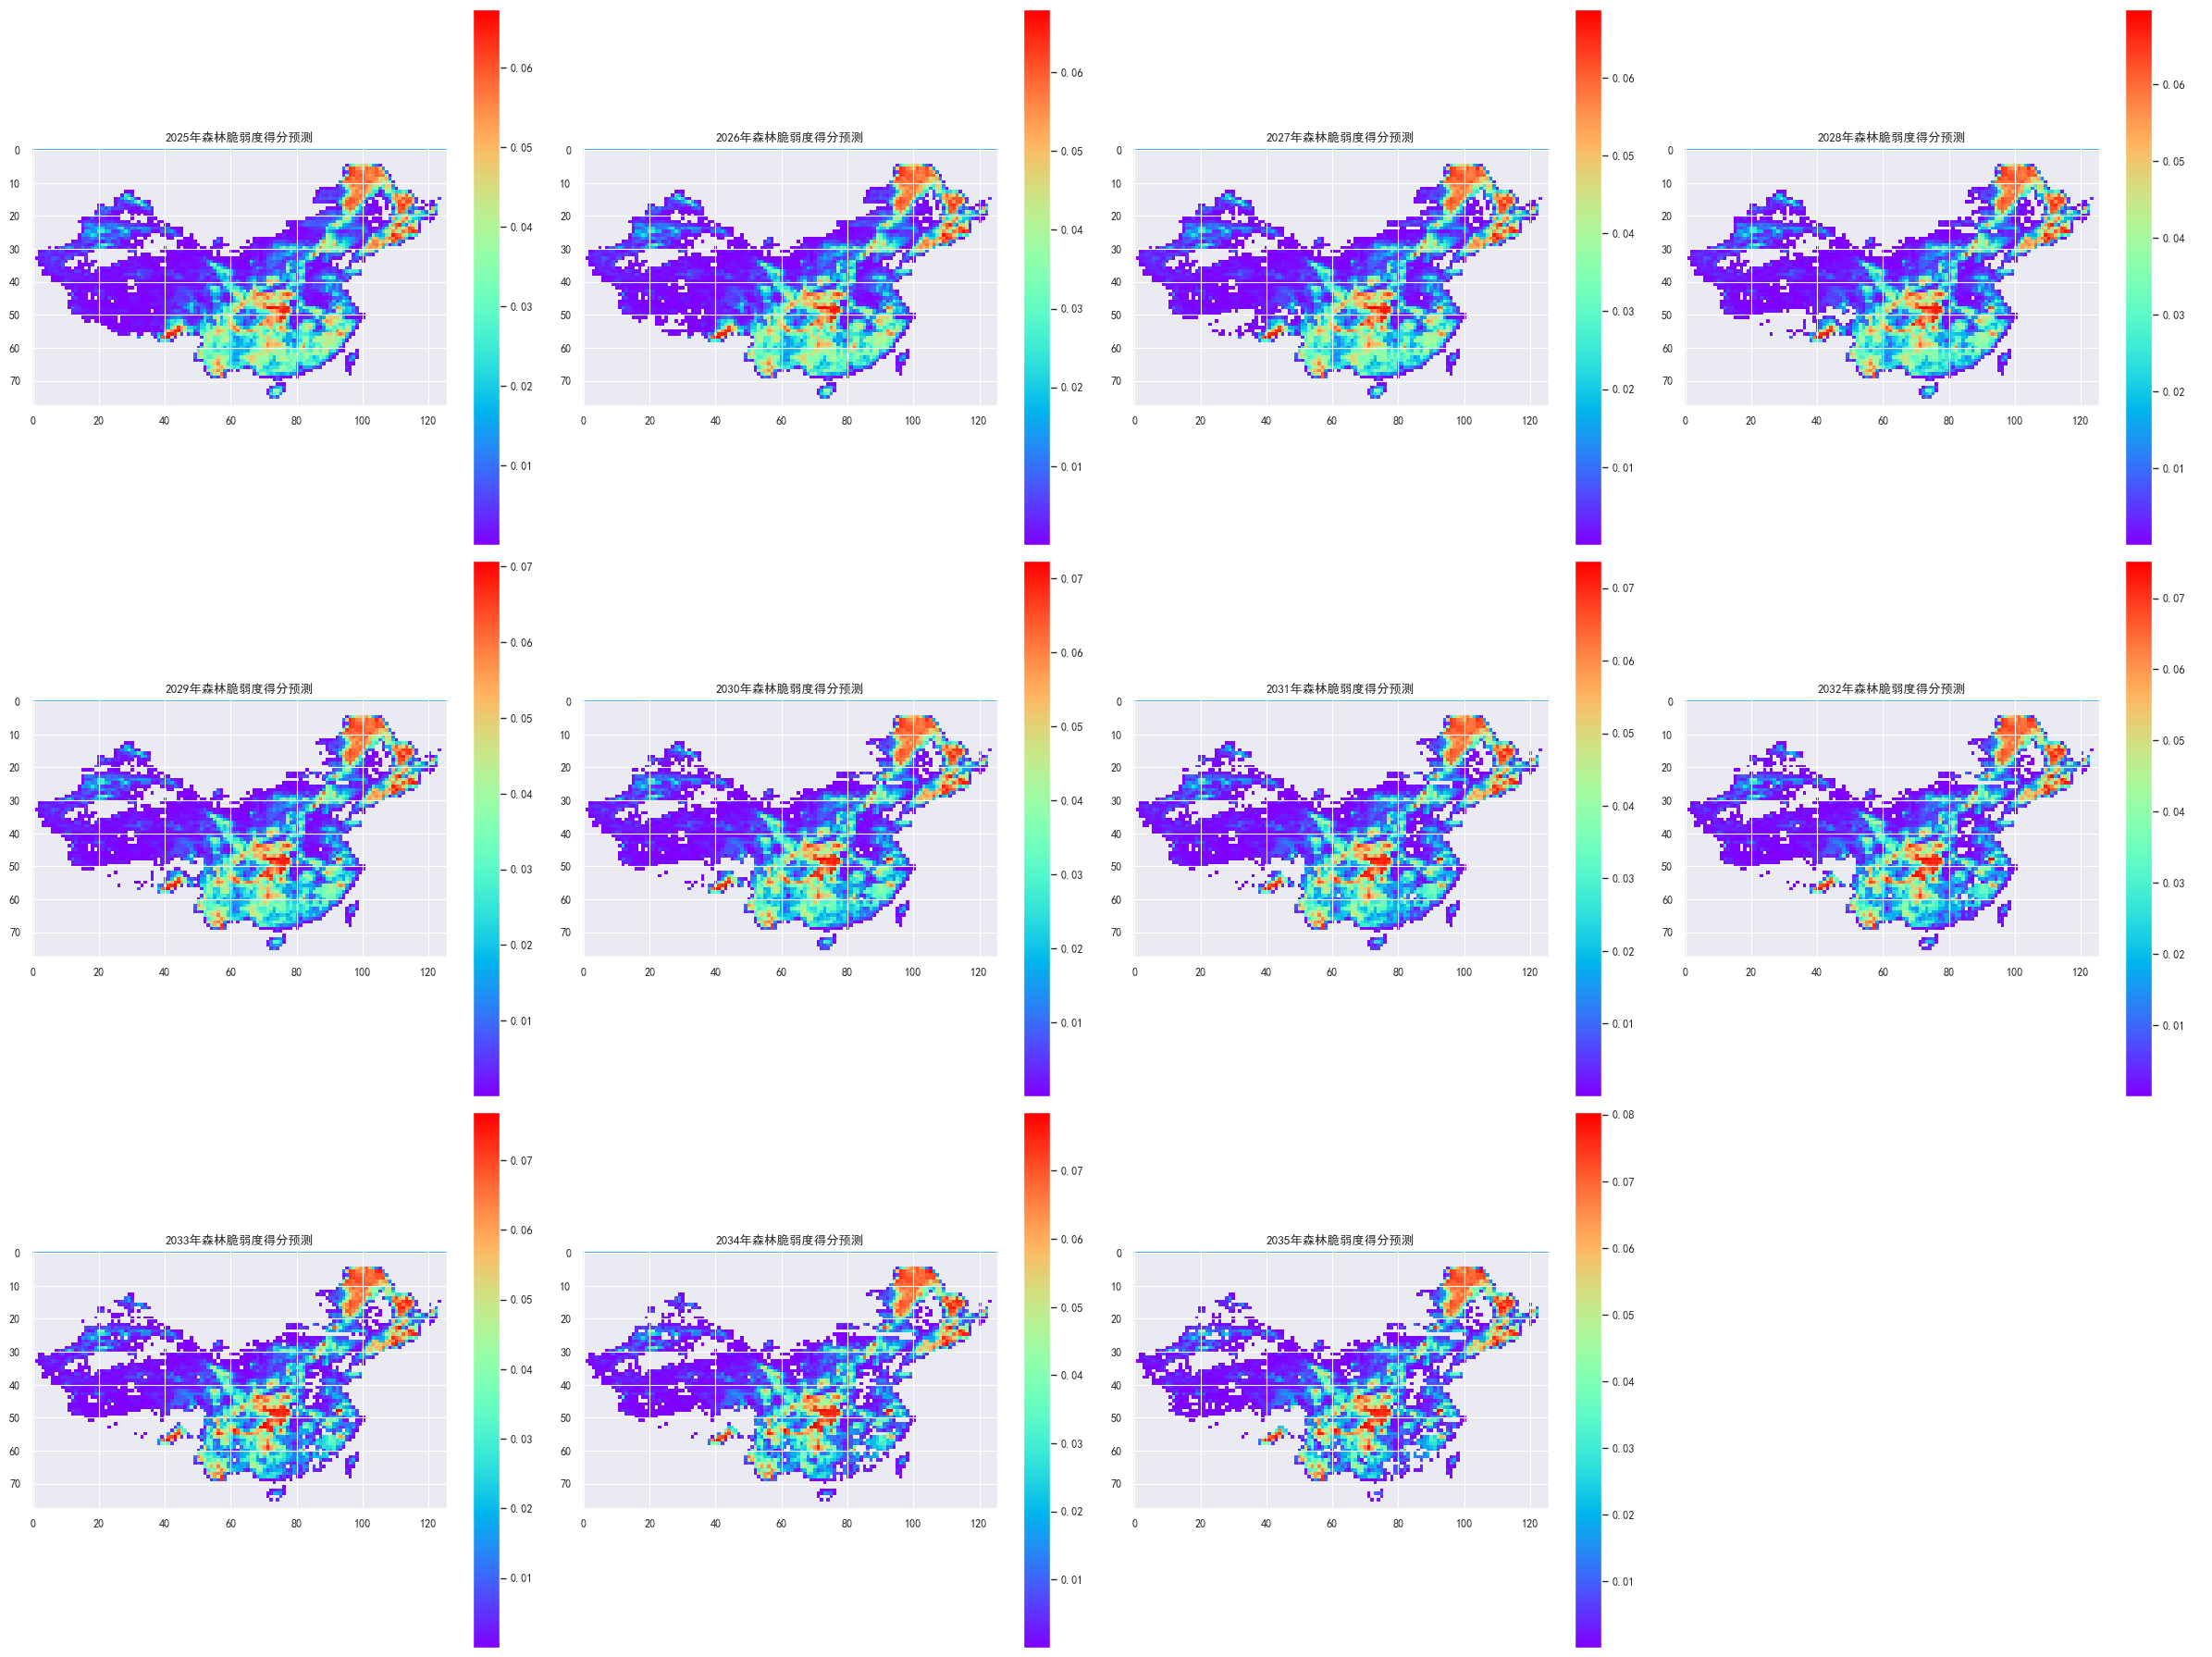

In [64]:
import warnings

# 忽略所有的警告
warnings.filterwarnings("ignore")
# 设置字体为 SimHei（黑体）以支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 解决负号
excel_file_path = 'F:\研究生学习\华为杯\第三问最终代码\python\\forest_data1.xlsx' 
excel_data = pd.ExcelFile(excel_file_path)
sheet_names = excel_data.sheet_names 

fig,axes = plt.subplots(3,4,figsize=(24,18))
for idx, sheet_name in enumerate(sheet_names):
    year = int(sheet_name.split()[0])
    matrix = excel_data.parse(sheet_name).values
    l2 = l2_normalize_matrix(matrix)
    l3 = pd.DataFrame(l2)
    l3=l3.replace(0,np.nan) 
    # ax = axes[idx // 2, idx % 2]  
    row = idx // 4  # 整数除法得到行索引  
    col = idx % 4   # 求余得到列索引  
    ax = axes[row, col] 
    cax = ax.imshow(l3,cmap='rainbow')
    fig.colorbar(cax,ax=ax)
    ax.set_title(f'{year}年森林脆弱度得分预测')

axes[-1,-1].axis('off')     
plt.tight_layout()
plt.savefig('F:\研究生学习\华为杯\第三问图片\\forest脆弱度得分.png',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')
plt.show()

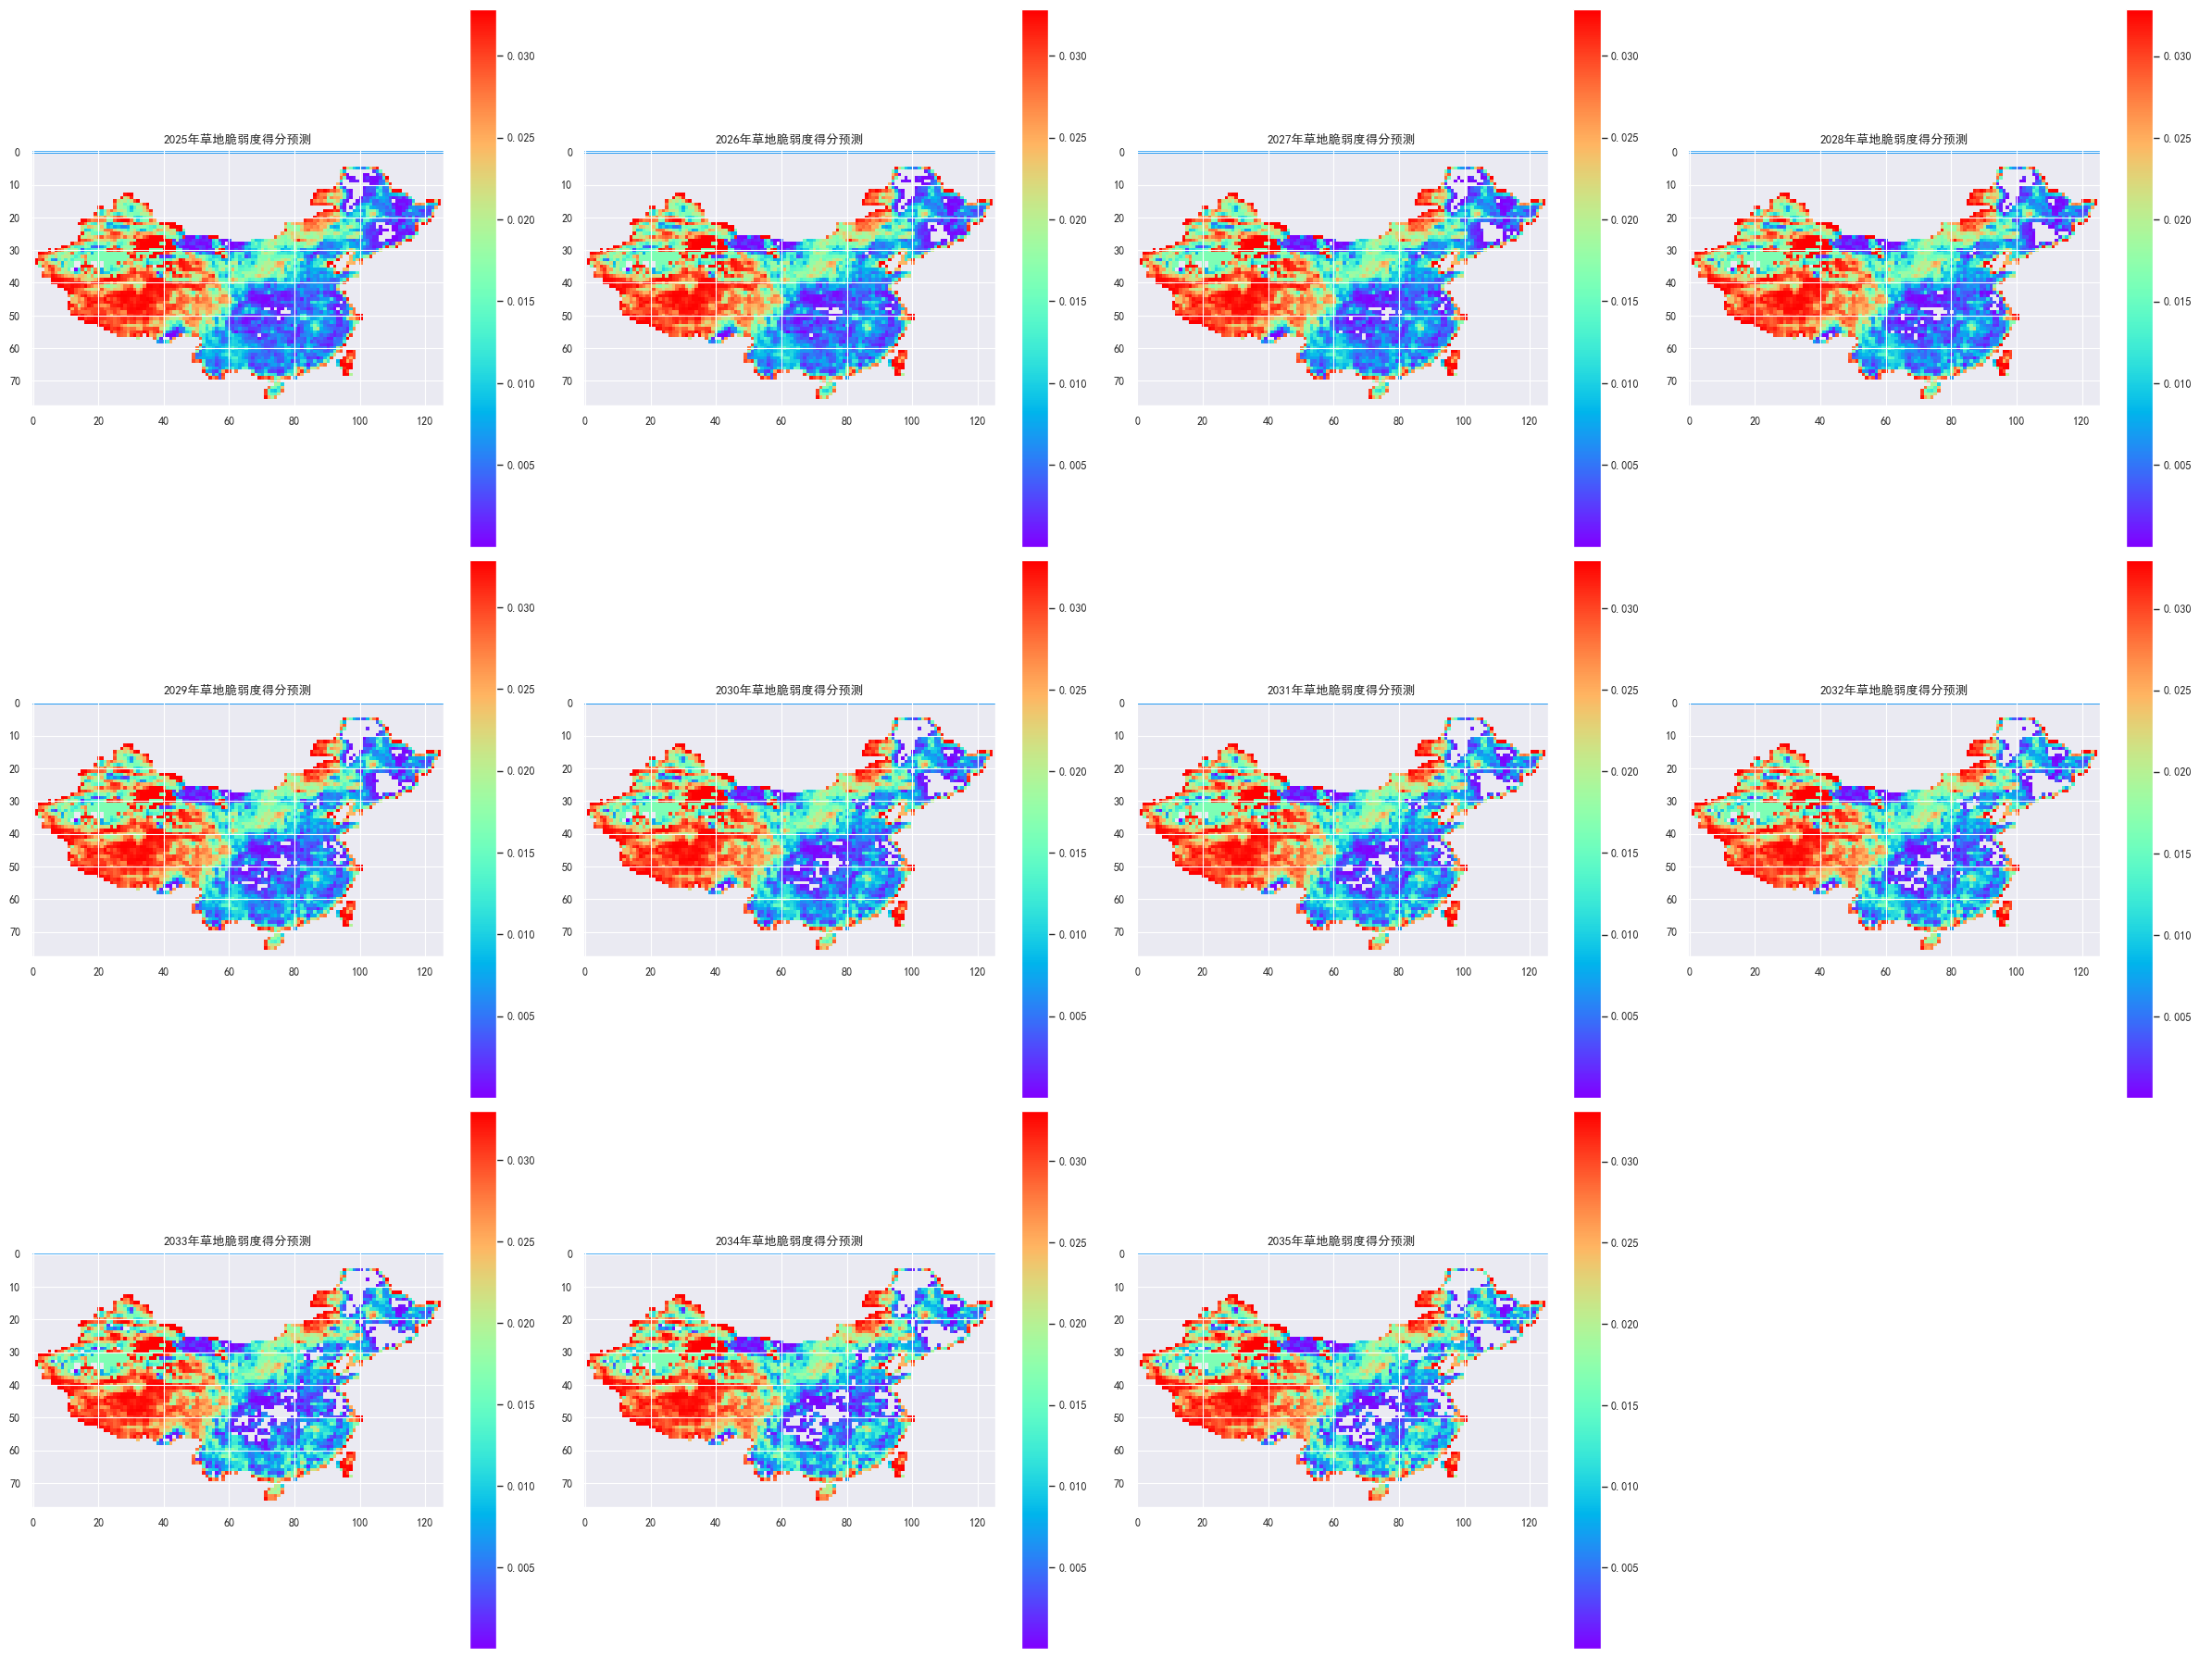

In [63]:
import warnings

# 忽略所有的警告
warnings.filterwarnings("ignore")
# 设置字体为 SimHei（黑体）以支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 解决负号
excel_file_path = 'F:\研究生学习\华为杯\第三问最终代码\python\\grass_data1.xlsx' 
excel_data = pd.ExcelFile(excel_file_path)
sheet_names = excel_data.sheet_names 

fig,axes = plt.subplots(3,4,figsize=(24,18))
for idx, sheet_name in enumerate(sheet_names):
    year = int(sheet_name.split()[0])
    matrix = excel_data.parse(sheet_name).values
    l2 = l2_normalize_matrix(matrix)
    l3 = pd.DataFrame(l2)
    l3=l3.replace(0,np.nan) 
    # ax = axes[idx // 2, idx % 2]  
    row = idx // 4  # 整数除法得到行索引  
    col = idx % 4   # 求余得到列索引  
    ax = axes[row, col] 
    cax = ax.imshow(l3,cmap='rainbow')
    fig.colorbar(cax,ax=ax)
    ax.set_title(f'{year}年草地脆弱度得分预测')

axes[-1,-1].axis('off')     
plt.tight_layout()
plt.savefig('F:\研究生学习\华为杯\第三问图片\\grass脆弱度得分.png',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')
plt.show()

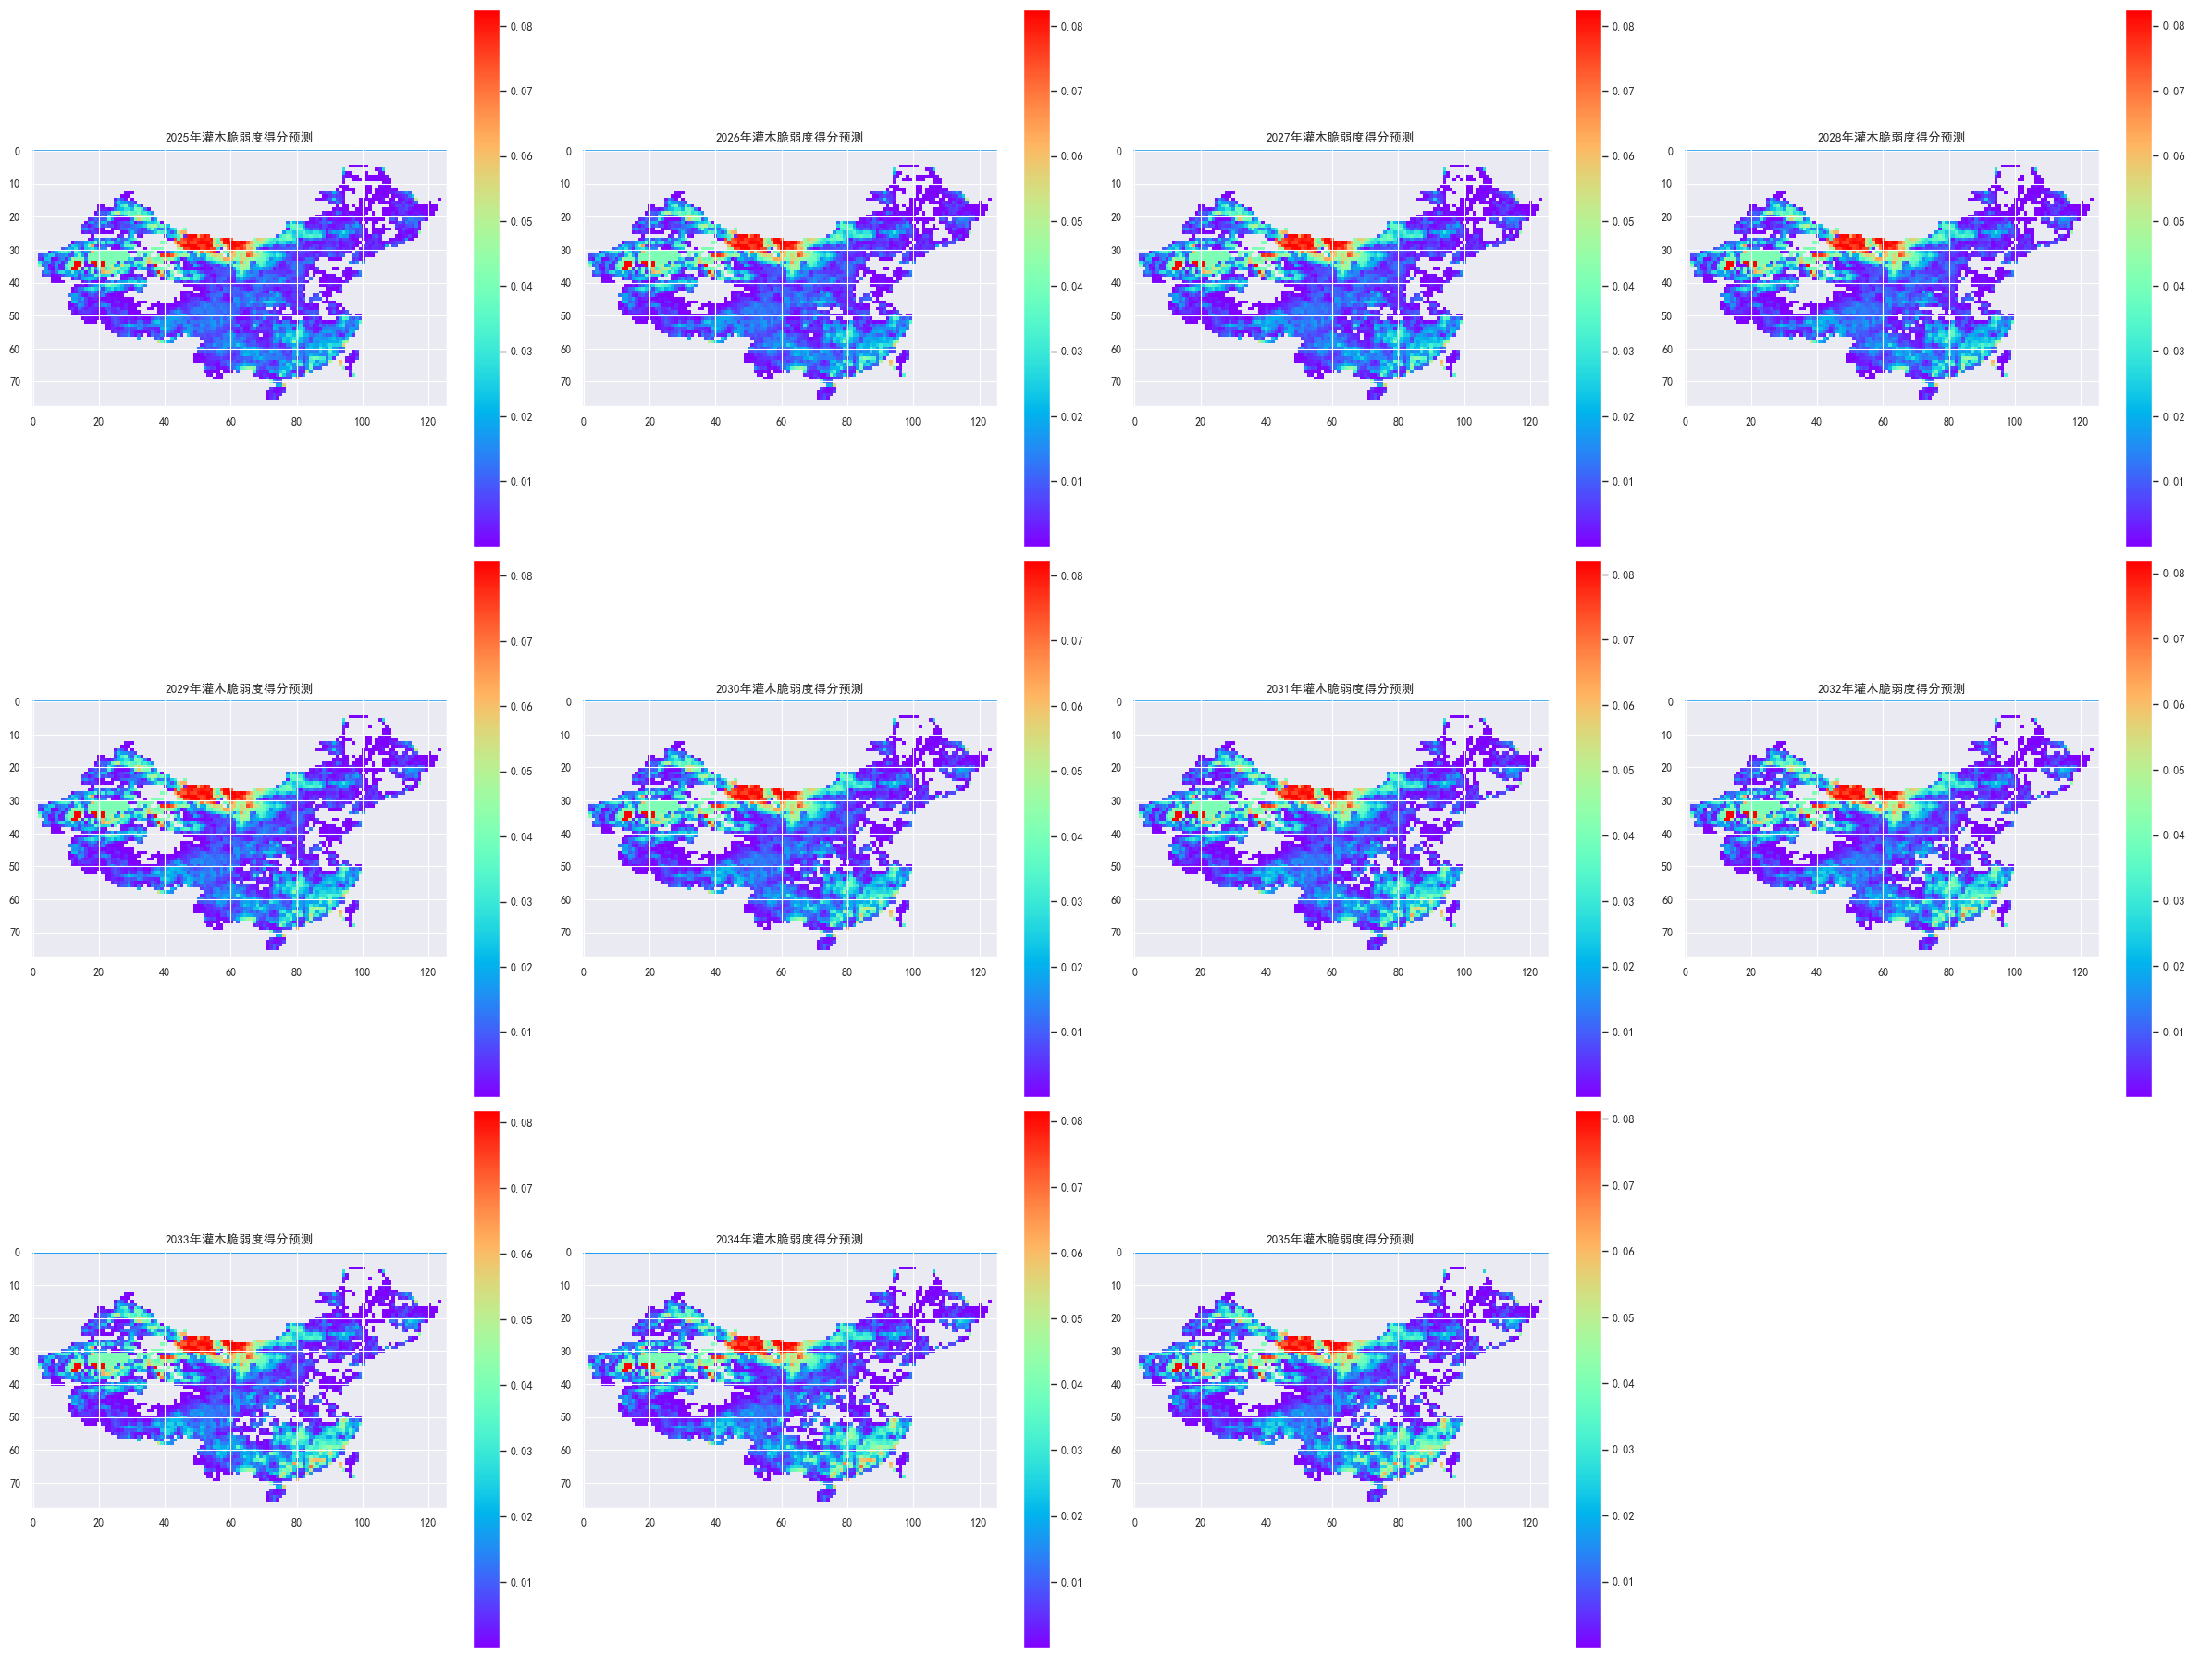

In [62]:
import warnings

# 忽略所有的警告
warnings.filterwarnings("ignore")
# 设置字体为 SimHei（黑体）以支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 解决负号
excel_file_path = 'F:\研究生学习\华为杯\第三问最终代码\python\\shrub_data1.xlsx' 
excel_data = pd.ExcelFile(excel_file_path)
sheet_names = excel_data.sheet_names 

fig,axes = plt.subplots(3,4,figsize=(24,18))
for idx, sheet_name in enumerate(sheet_names):
    year = int(sheet_name.split()[0])
    matrix = excel_data.parse(sheet_name).values
    l2 = l2_normalize_matrix(matrix)
    l3 = pd.DataFrame(l2)
    l3=l3.replace(0,np.nan) 
    # ax = axes[idx // 2, idx % 2]  
    row = idx // 4  # 整数除法得到行索引  
    col = idx % 4   # 求余得到列索引  
    ax = axes[row, col] 
    cax = ax.imshow(l3,cmap='rainbow')
    fig.colorbar(cax,ax=ax)
    ax.set_title(f'{year}年灌木脆弱度得分预测')

axes[-1,-1].axis('off')     
plt.tight_layout()
plt.savefig('F:\研究生学习\华为杯\第三问图片\\shrub脆弱度得分.png',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')
plt.show()

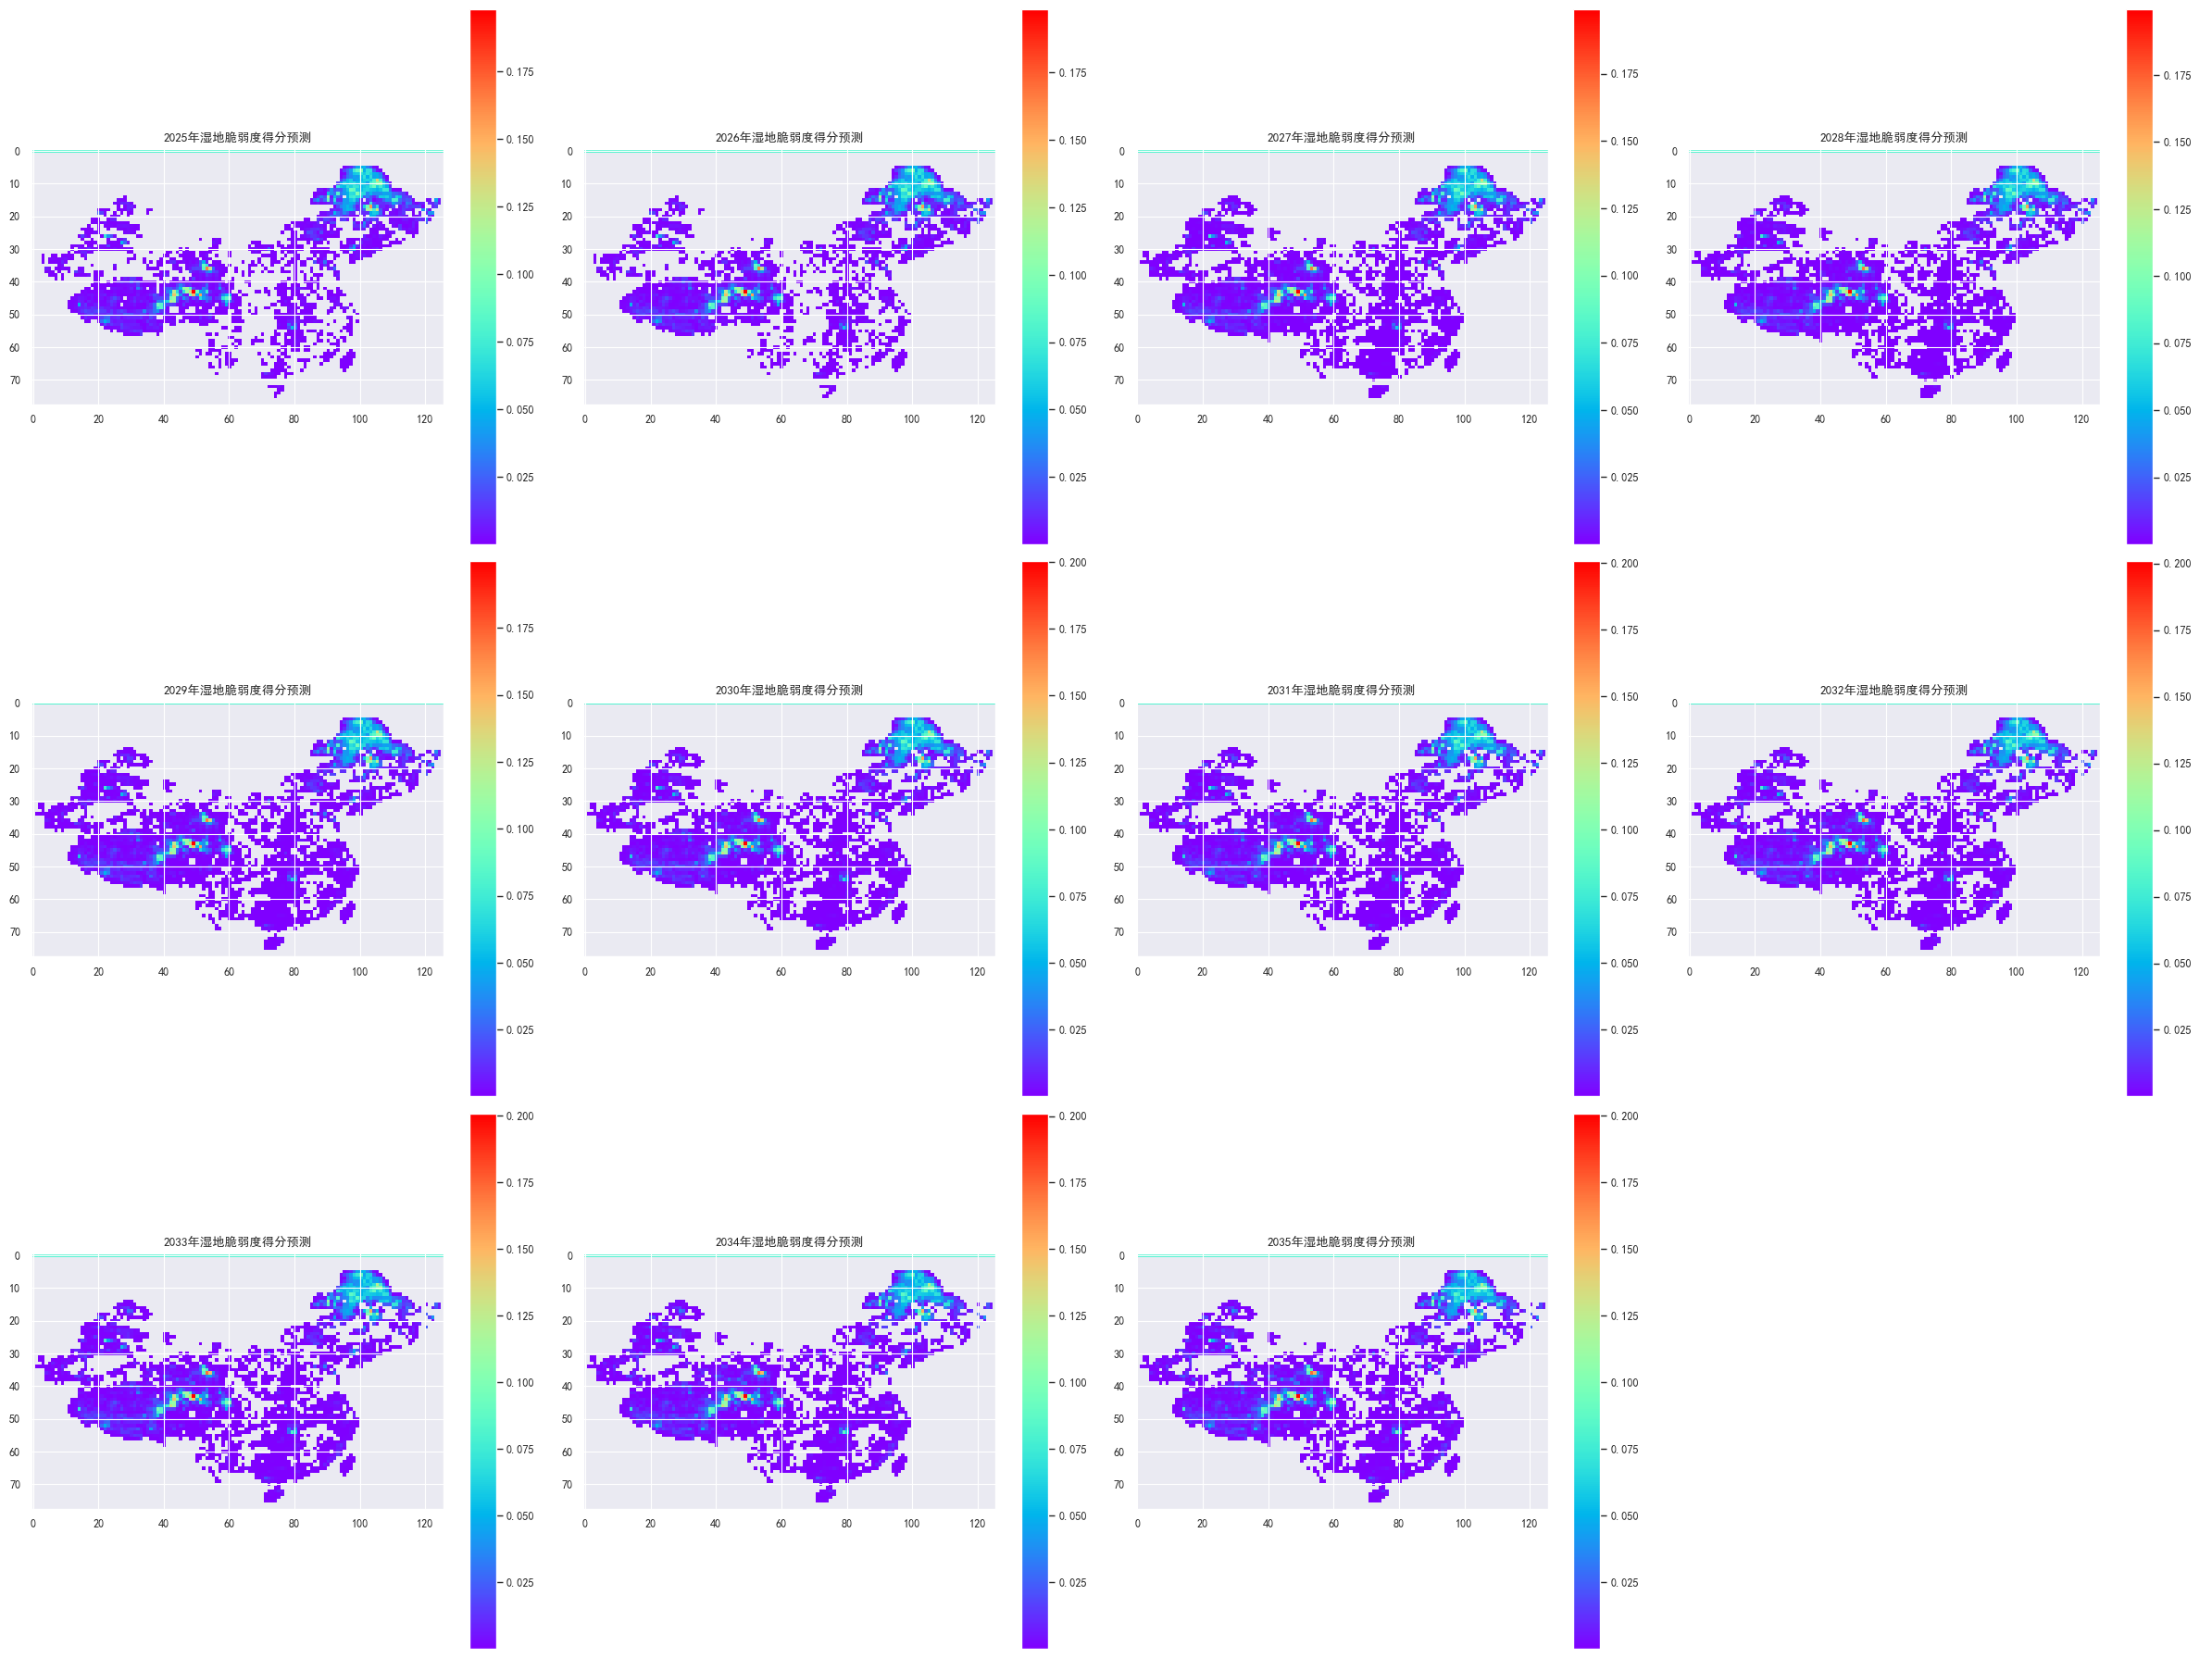

In [61]:
import warnings

# 忽略所有的警告
warnings.filterwarnings("ignore")
# 设置字体为 SimHei（黑体）以支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 解决负号
excel_file_path = 'F:\研究生学习\华为杯\第三问最终代码\python\\wet_data1.xlsx' 
excel_data = pd.ExcelFile(excel_file_path)
sheet_names = excel_data.sheet_names 

fig,axes = plt.subplots(3,4,figsize=(24,18))
for idx, sheet_name in enumerate(sheet_names):
    year = int(sheet_name.split()[0])
    matrix = excel_data.parse(sheet_name).values
    l2 = l2_normalize_matrix(matrix)
    l3 = pd.DataFrame(l2)
    l3=l3.replace(0,np.nan) 
    # ax = axes[idx // 2, idx % 2]  
    row = idx // 4  # 整数除法得到行索引  
    col = idx % 4   # 求余得到列索引  
    ax = axes[row, col] 
    cax = ax.imshow(l3,cmap='rainbow')
    fig.colorbar(cax,ax=ax)
    ax.set_title(f'{year}年湿地脆弱度得分预测')

axes[-1,-1].axis('off')     
plt.tight_layout()
plt.savefig('F:\研究生学习\华为杯\第三问图片\\wet脆弱度得分.png',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')
plt.show()